#**Proyecto Análisis de Video**

Integrantes: Matías Bozo y Jorge Morales

Se instalan las bibliotecas necesarias para trabajar con videos y modelos en PyTorch. Además, se utiliza `IPython.display` para limpiar la salida de la celda, eliminando mensajes innecesarios generados durante las instalaciones, y así mantener el notebook más organizado.

In [1]:
!pip install pytorchvideo   # Biblioteca para tareas de video con PyTorch
!pip install torchsummary   # Bibiloteca para resumir arquitecturas
!pip install kaggle         # Biblioteca para interactuar con la API de Kaggle

from IPython import display
display.clear_output()

Se utiliza la funcionalidad de Google Colab para subir archivos desde el sistema local al entorno de trabajo. Esto es necesario para subir el archivo kaggle.json, que contiene las credenciales de la API de Kaggle, permitiendo descargar datasets directamente desde Kaggle.

In [2]:
from google.colab import files

# Subir el archivo kaggle.json desde el sistema local al entorno de Colab
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matasbozopizarro","key":"ecd5b25ccfa3da91e256871c16d8c92a"}'}

Se configuran las credenciales de la API de Kaggle. Se crea el directorio necesario para almacenar el archivo kaggle.json, se mueve el archivo a ese directorio y se ajustan los permisos para garantizar la seguridad

In [3]:
# Crear un directorio para Kaggle
!mkdir -p ~/.kaggle

# Mover el archivo kaggle.json subido al directorio de Kaggle
!cp kaggle.json ~/.kaggle/

# Cambiar los permisos del archivo para mayor seguridad
!chmod 600 ~/.kaggle/kaggle.json

Se descarga el dataset desde Kaggle utilizando la API de Kaggle. El parámetro `-d` indica el dataset a descargar, en este caso, "real-life-violence-situations-dataset".


In [4]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset
License(s): copyright-authors
100% 3.58G/3.58G [00:33<00:00, 129MB/s]
100% 3.58G/3.58G [00:33<00:00, 114MB/s]


Se descomprime el archivo descargado desde Kaggle (en formato .zip) en un directorio específico. Se define la ruta del archivo comprimido, se especifica un directorio de extracción y se descomprimen los contenidos.

In [5]:
import zipfile              # Biblioteca para manejar archivos comprimidos ZIP
import os                   # Biblioteca para manejar operaciones de sistema de archivos

# Especificar la ruta del archivo ZIP descargado
zip_file_path = '/content/real-life-violence-situations-dataset.zip'

# Especificar la ruta donde se descomprimirá el archivo
extraction_path = '/content/real-life-violence-situations-dataset/'

# Crear el directorio de extracción si no existe
os.makedirs(extraction_path, exist_ok=True)

# Descomprimir el archivo
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Listar los archivos en el directorio de extracción para verificar
extracted_files = os.listdir(extraction_path)
print("Archivos extraídos:", extracted_files)

Archivos extraídos: ['Real Life Violence Dataset', 'real life violence situations']


In [6]:
from google.colab import drive  # Importar la funcionalidad para trabajar con Google Drive

# Montar Google Drive en el entorno de trabajo de Colab
drive.mount('/content/drive')

Mounted at /content/drive


 Se importan las bibliotecas necesarias para el procesamiento, manipulación de datos, división de conjuntos de datos y uso de PyTorch.

In [44]:
import torch                                # Biblioteca principal para el cálculo numérico y aprendizaje profundo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision                          # Extensión de PyTorch para tareas relacionadas con imágenes y videos
import torchvision.transforms as transforms # Herramientas para aplicar transformaciones a los datos
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


import cv2                                  # Biblioteca para procesamiento de imágenes y videos
import numpy as np                          # Biblioteca para cálculos numéricos con arreglos
import matplotlib.pyplot as plt
import random                               # Generación de números aleatorios
import shutil                               # Manejo de operaciones con archivos y directorios
import copy                                 # Copias profundas y superficiales de objetos en Python
import os
import copy

from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba

Se definen las rutas para el dataset original y los datos preprocesados, así como parámetros importantes para la manipulación de videos y las clases que serán usadas en el modelo.

In [8]:
# Definir ruta del dataset original descomprimido
ds_input_path = '/content/real-life-violence-situations-dataset/Real Life Violence Dataset'

# Definir ruta donde se almacenarán los datos preprocesados
ds_preprocessed_path = '/content/processed-dataset/'

# Definir rutas para los conjuntos de datos de entrenamiento, validación y prueba
train_path = os.path.join(ds_preprocessed_path, 'train')
os.makedirs(train_path, exist_ok=True)

val_path = os.path.join(ds_preprocessed_path, 'val')
os.makedirs(val_path, exist_ok=True)

test_path = os.path.join(ds_preprocessed_path, 'test')
os.makedirs(test_path, exist_ok=True)

# Definir parámetros relacionados con los videos
NUM_FRAMES = 16  # Número de frames que se procesarán por video
FRAME_W = 256    # Ancho de cada frame (dimensiones de la imagen)
FRAME_H = 256    # Alto de cada frame (dimensiones de la imagen)

# Definir clases objetivo del dataset
CLASS_NAMES = ['Violence', 'NonViolence']  # Nombres de las clases de los datos

Para inspeccionar los datos, se obtiene información básica de los videos, como la resolución y el número de frames de cada video.

In [9]:
# Recorrer recursivamente el directorio de entrada
for idx, (root, dirs, files) in enumerate(os.walk(ds_input_path)):
    for filename in files:
        # Obtener la ruta completa del archivo
        file_path = os.path.join(root, filename)

        # Procesar solo los archivos con extensión .mp4
        if file_path.endswith('.mp4'):
            # Crear un objeto VideoCapture para leer el video
            cap = cv2.VideoCapture(file_path)

            # Obtener la resolución (ancho y alto) y el número de frames
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Imprimir información básica del video
            print(f"Video: {filename} | Número de frames: {num_frames} - Resolución: {width} x {height}")

            # Liberar el objeto VideoCapture
            cap.release()

        # Salir después de procesar 10 videos
        if idx >= 10:
            break

Video: NV_424.mp4 | Número de frames: 55 - Resolución: 224 x 224
Video: NV_499.mp4 | Número de frames: 115 - Resolución: 224 x 224
Video: NV_680.mp4 | Número de frames: 120 - Resolución: 224 x 224
Video: NV_805.mp4 | Número de frames: 115 - Resolución: 224 x 224
Video: NV_607.mp4 | Número de frames: 105 - Resolución: 224 x 224
Video: NV_23.mp4 | Número de frames: 132 - Resolución: 1280 x 720
Video: NV_659.mp4 | Número de frames: 145 - Resolución: 224 x 224
Video: NV_192.mp4 | Número de frames: 125 - Resolución: 224 x 224
Video: NV_535.mp4 | Número de frames: 145 - Resolución: 224 x 224
Video: NV_244.mp4 | Número de frames: 125 - Resolución: 224 x 224
Video: NV_725.mp4 | Número de frames: 120 - Resolución: 640 x 360
Video: NV_420.mp4 | Número de frames: 55 - Resolución: 224 x 224
Video: NV_655.mp4 | Número de frames: 145 - Resolución: 224 x 224
Video: NV_447.mp4 | Número de frames: 55 - Resolución: 224 x 224
Video: NV_817.mp4 | Número de frames: 115 - Resolución: 224 x 224
Video: NV_629

Se define función encargada de preprocesar un video, guardándolo como archivo `.npy`.


In [10]:
def preprocess_video(video_path, output_path, num_frames=NUM_FRAMES, resize=(FRAME_W, FRAME_H)):
    # Crear un objeto VideoCapture para leer el video
    cap = cv2.VideoCapture(video_path)
    frames = []  # Lista para almacenar los frames del video

    # Leer los frames del video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Salir del bucle si no hay más frames

        # Convertir el frame de BGR a RGB y redimensionarlo
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, resize)

        # Añadir el frame procesado a la lista
        frames.append(frame)

    # Liberar el objeto VideoCapture
    cap.release()

    # Convertir los frames a un array de NumPy
    frames = np.array(frames)

    # Muestrear los frames
    if len(frames) > num_frames:
        # Seleccionar un número fijo de frames de manera uniforme
        indices = np.linspace(0, len(frames) - 1, num_frames).astype(int)
        sampled_frames = frames[indices]
    elif len(frames) < num_frames:
        # Rellenar con frames vacíos si hay menos de los necesarios
        padding = np.zeros((num_frames - len(frames), *resize, 3))
        sampled_frames = np.concatenate((frames, padding), axis=0)
    else:
        sampled_frames = frames  # Usar los frames directamente si tienen la cantidad exacta

    # Guardar los frames preprocesados en un archivo .npy
    np.save(output_path, sampled_frames)


Se define una función que realiza el preprocesamiento de videos y divide los datos en conjuntos de entrenamiento, validación y prueba.

In [13]:
def split_and_preprocess_videos(input_folder, train_dir, val_dir, test_dir, frame_size):
    for class_name in CLASS_NAMES:
        class_folder = os.path.join(input_folder, class_name)

        # Obtener todos los archivos de video en la carpeta de la clase
        videos = [f for f in os.listdir(class_folder) if f.endswith(('.mp4', '.avi', '.mov'))]

        # Dividir los videos en conjuntos de entrenamiento, validación y prueba
        train_videos, temp_videos = train_test_split(videos, test_size=0.2, random_state=42)
        val_videos, test_videos = train_test_split(temp_videos, test_size=0.5, random_state=42)

        # Crear un diccionario para los conjuntos divididos
        splits = {'train': train_videos, 'val': val_videos, 'test': test_videos}

        # Iterar sobre los conjuntos divididos
        for split in splits:
            # Definir la carpeta de salida correspondiente
            split_folder = os.path.join(train_dir if split == 'train' else val_dir if split == 'val' else test_dir, class_name)
            os.makedirs(split_folder, exist_ok=True)  # Crear la carpeta si no existe

            # Procesar cada video y guardarlo en el formato preprocesado
            for video in splits[split]:
                video_path = os.path.join(class_folder, video)  # Ruta completa del video original
                output_path = os.path.join(split_folder, video.replace('.mp4', '.npy'))  # Ruta para guardar el archivo preprocesado
                preprocess_video(video_path, output_path, NUM_FRAMES, frame_size)  # Preprocesar el video
                print(f"Archivo {video} procesado y guardado en {split_folder}")  # Mensaje de confirmación

Se instancia la función `split_and_preprocess_videos`.

In [14]:
split_and_preprocess_videos(input_folder= ds_input_path, train_dir= train_path, val_dir= val_path, test_dir= test_path, frame_size = (FRAME_W, FRAME_H))

Archivo V_168.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_229.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_420.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_266.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_125.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_174.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_691.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_768.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_996.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_70.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_597.mp4 procesado y guardado en /content/processed-dataset/train/Violence
Archivo V_867.mp4 procesado y guardado en /content/processed-dataset/train/Vi

Se configura el dispositivo de cómputo (CPU o GPU) para el procesamiento de datos y entrenamiento del modelo. Además, se establecen los parámetros clave para el procesamiento de los datos.

In [23]:
# Configurar del dispositivo (CPU o GPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo configurado: {DEVICE}')

# Definir parámetros de procesamiento de datos
BATCH_SIZE = 8     # Tamaño del lote para el entrenamiento
NUM_EPOCHS = 2     # Número de épocas de entrenamiento
NUM_FRAMES = 16    # Número de frames por video a procesar
FRAME_W = 256      # Ancho de cada frame
FRAME_H = 256      # Alto de cada frame

Dispositivo configurado: cpu


Se define una función para contar el número de muestras en cada categoría (`Violence`, `NonViolence`) dentro de los subconjuntos (`train`, `val`, `test`) de un directorio de datos.

In [24]:
def count_samples(data_dir):
    counts = {}  # Definir diccionario para almacenar los conteos
    for subset in ['train', 'val', 'test']:  # Iterar sobre los subconjuntos de datos
        subset_path = os.path.join(data_dir, subset)
        counts[subset] = {}
        for category in ['Violence', 'NonViolence']:  # Iterar sobre las categorías
            category_path = os.path.join(subset_path, category)
            num_samples = len(os.listdir(category_path))
            counts[subset][category] = num_samples
    return counts

Se instancia la función `count_samples` y se muestra por consola, el número de muestras por subconjunto.

In [31]:
sample_counts = count_samples(ds_preprocessed_path)

for subset, categories in sample_counts.items():
    print(f"{subset} set:")
    for category, count in categories.items():
        print(f"  {category}: {count} samples")

train set:
  Violence: 800 samples
  NonViolence: 800 samples
val set:
  Violence: 100 samples
  NonViolence: 100 samples
test set:
  Violence: 100 samples
  NonViolence: 100 samples


Se define la clase `VideoDataset`, que extiende la clase base `Dataset` de PyTorch y está diseñada para manejar datasets de videos preprocesados almacenados como archivos `.npy`.

In [34]:
class VideoDataset(Dataset):
    # Definir constructor de la clase VideoDataset
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Violence', 'NonViolence']
        self.frame_paths = []
        self.labels = []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for frame_file in os.listdir(class_dir):
                frame_path = os.path.join(class_dir, frame_file)
                self.frame_paths.append(frame_path)
                self.labels.append(label)
    # Definir función que devuelve la cantidad total de elementos en el dataset
    def __len__(self):
        return len(self.frame_paths)
    # Definir función que devuelve los frames y la etiqueta para un índice específico
    def __getitem__(self, idx):
        frame_path = self.frame_paths[idx]
        label = self.labels[idx]
        frames = np.load(frame_path)
        if self.transform:
            frames = self.transform(frames)
        return frames, label

Se define la clase `ToTensor`, que convierte un conjunto de frames (en formato NumPy) a un tensor de PyTorch, con formato adecuado para el modelo X3D.

In [35]:
class ToTensor(object):
    # Convertir un conjunto de frames de NumPy a un tensor de PyTorch y normaliza los valores
    def __call__(self, sample):
        frames = sample
        # Cambiar el orden de los ejes (T, H, W, C) a (C, T, H, W)
        frames = frames.transpose((3, 0, 1, 2))
        # Convertir de NumPy a tensor de PyTorch
        frames = torch.from_numpy(frames).float()
        # Normalizar los valores de los píxeles al rango [0, 1]
        frames = frames / 255.0
        return frames


* Se construyen las rutas para los datos de entrenamiento, validación y prueba.
* Se definen las transformaciones de datos.
* Se crean los datasets correspondientes utilizando la clase `VideoDataset`.
* Se generan los `DataLoaders` para procesar los datos en lotes durante el entrenamiento y la evaluación.

In [36]:
# Construir correctamente las rutas para train, val y test
train_dir = os.path.join(ds_preprocessed_path, 'train')
val_dir = os.path.join(ds_preprocessed_path, 'val')
test_dir = os.path.join(ds_preprocessed_path, 'test')

# Transformar datos
data_transforms = {
    'train': transforms.Compose([ToTensor()]),
    'val': transforms.Compose([ToTensor()]),
    'test': transforms.Compose([ToTensor()]),
}

# Crear datasets para train, val y test
train_dataset = VideoDataset(root_dir=train_dir, transform=data_transforms['train'])
val_dataset = VideoDataset(root_dir=val_dir, transform=data_transforms['val'])
test_dataset = VideoDataset(root_dir=test_dir, transform=data_transforms['test'])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Se verifica que los `DataLoaders` estén funcionando correctamente al iterar sobre un lote del conjunto de entrenamiento (`train_loader`).

In [37]:
# Comprobar los DataLoaders
for i, (videos, labels) in enumerate(train_loader):
        print(videos.shape, labels.shape)
        break

torch.Size([8, 3, 16, 256, 256]) torch.Size([8])


Se define una función que permite personalizar el modelo preentrenado X3D de PyTorchVideo para realizar fine-tuning en una tarea de clasificación con un número específico de clases. Reemplaza la capa final del modelo con una capa totalmente conectada (`Linear`) adaptada al número de clases objetivo.

In [41]:
def custome_X3D(num_classes):
    # Cargar el modelo preentrenado
    model_name = 'x3d_m' # Especificar la variante de modelo X3D
    model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=True)
    input_size = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = nn.Linear(in_features=input_size, out_features=num_classes) # Reemplazar la última capa
    return model

Se define una función que implementa el proceso de entrenamiento para un modelo de PyTorch. Toma un lote de datos, realiza un pase hacia adelante, calcula la pérdida, realiza un pase hacia atrás (backpropagation), y actualiza los pesos del modelo utilizando un optimizador.

In [40]:
# Entrena el modelo durante una época.
def train(model, loader, optimizer, criterion):
    model.train()  # Poner el modelo en modo de entrenamiento
    running_loss = 0.0  # Acumular la pérdida total
    correct = 0         # Contar predicciones correctas
    total = 0           # Contar el número total de muestras

    for videos, labels in loader:
        # Mover los datos al dispositivo configurado (CPU o GPU)
        videos, labels = videos.to(DEVICE), labels.to(DEVICE)

        # Reiniciar los gradientes del optimizador
        optimizer.zero_grad()

        # Pase hacia adelante: calcular las salidas del modelo
        outputs = model(videos)

        # Calcular la pérdida
        loss = criterion(outputs, labels)

        # Pase hacia atrás: calcular los gradientes
        loss.backward()

        # Actualizar los pesos del modelo
        optimizer.step()

        # Acumular la pérdida total
        running_loss += loss.item()

        # Obtener las predicciones del modelo
        _, predicted = outputs.max(1)

        # Actualizar el total de muestras y las correctas
        total += labels.size(0)  # Sumar el tamaño del lote
        correct += predicted.eq(labels).sum().item()  # Sumar predicciones correctas

    # Calcular la pérdida promedio y la exactitud
    loss = running_loss / len(loader)  # Promedio de pérdida
    accuracy = correct / total         # Exactitud

    return loss, accuracy

Se define una función que evalúa el modelo en un conjunto de datos de validación o prueba. Calcula la pérdida y la precisión, deshabilitando el cálculo de gradientes para reducir el uso de memoria y acelerar el proceso.

In [39]:
# Evalúa el modelo en un conjunto de datos
def evaluate(model, loader, criterion):
    model.eval()  # Poner el modelo en modo de evaluación
    correct = 0         # Contador de predicciones correctas
    total = 0           # Contador de muestras totales
    running_loss = 0.0  # Acumulador de pérdida

    # Deshabilitar el cálculo de gradientes (optimización)
    with torch.no_grad():
        for inputs, labels in loader:
            # Mover los datos al dispositivo configurado (CPU o GPU)
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # Pase hacia adelante: calcular las salidas del modelo
            outputs = model(inputs)

            # Calcular la pérdida
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Obtener las predicciones del modelo
            _, predicted = torch.max(outputs.data, 1)

            # Actualizar los contadores
            total += labels.size(0)  # Sumar el tamaño del lote
            correct += (predicted == labels).sum().item()  # Contar predicciones correctas

    # Calcular la pérdida promedio y la precisión
    loss = running_loss / len(loader)  # Promedio de pérdida
    acc = correct / total              # Precisión

    return loss, acc

Se configura el modelo, el optimizador y la función de pérdida para el entrenamiento.

In [42]:
# Número de clases para la clasificación
num_classes = 2 # Violence - NonViolence

# Configurar el modelo X3D personalizado y moverlo al dispositivo
model = custome_X3D(num_classes).to(DEVICE)

# Configurar el optimizador Adam con una tasa de aprendizaje inicial
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/facebookresearch/pytorchvideo/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/X3D_M.pyth" to /root/.cache/torch/hub/checkpoints/X3D_M.pyth
100%|██████████| 29.4M/29.4M [00:00<00:00, 65.6MB/s]


 Se utiliza la función summary() para mostrar la estructura del modelo, los parámetros aprendibles y las dimensiones de las entradas y salidas en cada capa.

In [43]:
summary(model, input_size=(3,16,256,256), device=DEVICE.type, batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 24, 16, 128, 128]             648
            Conv3d-2     [-1, 24, 16, 128, 128]             120
       Conv2plus1d-3     [-1, 24, 16, 128, 128]               0
       BatchNorm3d-4     [-1, 24, 16, 128, 128]              48
              ReLU-5     [-1, 24, 16, 128, 128]               0
   ResNetBasicStem-6     [-1, 24, 16, 128, 128]               0
            Conv3d-7       [-1, 24, 16, 64, 64]             576
            Conv3d-8     [-1, 54, 16, 128, 128]           1,296
       BatchNorm3d-9     [-1, 54, 16, 128, 128]             108
             ReLU-10     [-1, 54, 16, 128, 128]               0
           Conv3d-11       [-1, 54, 16, 64, 64]           1,458
      BatchNorm3d-12       [-1, 54, 16, 64, 64]             108
           Conv3d-13           [-1, 8, 1, 1, 1]             440
             ReLU-14           [-1, 8, 

 Se implementa el bucle de entrenamiento y validación del modelo X3D. Adapta automáticamente el modelo para usar múltiples GPUs si están disponibles, y guarda el mejor modelo basado en la exactitud en el conjunto de validación.

In [ ]:
# Configurar el dispositivo (CPU o GPU disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Si hay múltiples GPUs, usar DataParallel para dividir el modelo
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)  # Envolver el modelo en DataParallel
    model = model.to(device)
else:
    model = model.to(device)  # Mover el modelo al dispositivo

# Inicializar listas para registrar métricas
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_model = None  # Variable para guardar el mejor modelo
best_acc = 0       # Mejor precisión en validación

#-- Bucle de entrenamiento --
for epoch in range(NUM_EPOCHS):
    # Entrenar el modelo en el conjunto de entrenamiento
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)

    # Evaluar el modelo en el conjunto de validación
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    # Guardar las pérdidas y exactitudes para análisis posterior
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Si la precisión en validación mejora, actualizar el mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model)

    # Imprimir el progreso de entrenamiento y validación
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, '
          f'Train Loss: {train_loss:.4f}, Train ACC: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val ACC: {val_acc:.4f}')

# Guardar el modelo final al final del entrenamiento
last_model = copy.deepcopy(model)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


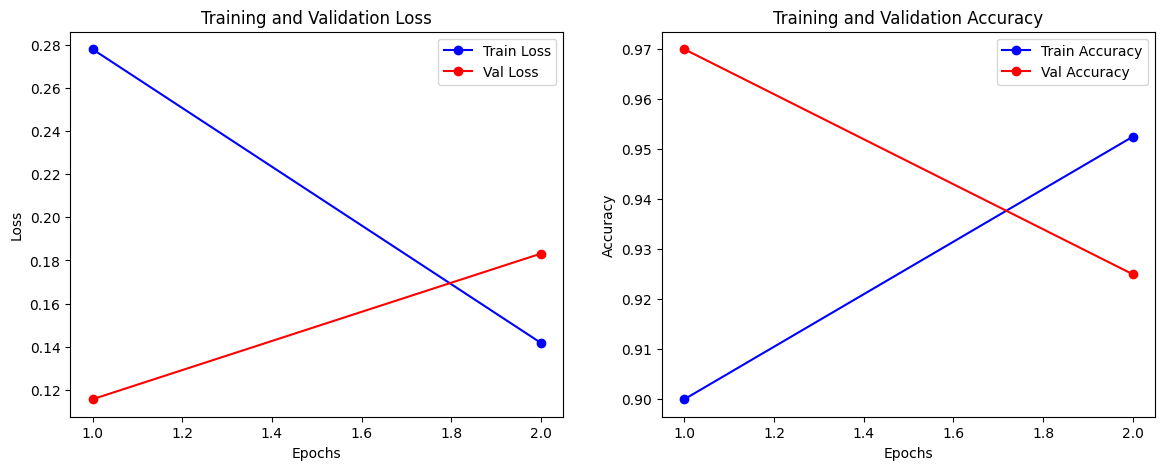

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)



plt.figure(figsize=(14, 5))



# Plot training & validation loss

plt.subplot(1, 2, 1)

plt.plot(epochs, train_losses, 'bo-', label='Train Loss')

plt.plot(epochs, val_losses, 'ro-', label='Val Loss')

plt.title('Training and Validation Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()



# Plot training & validation accuracy

plt.subplot(1, 2, 2)

plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')

plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')

plt.title('Training and Validation Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()



plt.show()

In [ ]:
import torch

# Guardar el modelo con PyTorch en Colab
torch.save(best_model.state_dict(), '/content/best_model.pth')
torch.save(last_model.state_dict(), '/content/last_model.pth')


In [ ]:
test_loss, test_acc = evaluate(best_model, test_loader, criterion)

print(f'Final Test Accuracy: {test_acc:.4f}')

Final Test Accuracy: 0.9700


In [ ]:
train_loss, train_acc = evaluate(last_model, train_loader, criterion)

val_loss, val_acc = evaluate(last_model, val_loader, criterion)

test_loss, test_acc = evaluate(last_model, test_loader, criterion)



print('Last Weights:\n'

         f'Train Loss: {train_loss: .4f} - Train ACC: {train_acc: .4f}\n'

         f'Val Loss: {val_loss: .4f} - Val ACC: {val_acc: .4f}\n'

         f'Test Loss: {test_loss: .4f} - Test ACC: {test_acc: .4f}')



#-- best model --

train_loss, train_acc = evaluate(best_model, train_loader, criterion)

val_loss, val_acc = evaluate(best_model, val_loader, criterion)

test_loss, test_acc = evaluate(best_model, test_loader, criterion)



print('\n\nBest Weights:\n'

         f'Train Loss: {train_loss: .4f} - Train ACC: {train_acc: .4f}\n'

         f'Val Loss: {val_loss: .4f} - Val ACC: {val_acc: .4f}\n'

         f'Test Loss: {test_loss: .4f} - Test ACC: {test_acc: .4f}')

Last Weights:
Train Loss:  0.0543 - Train ACC:  0.9819
Val Loss:  0.1832 - Val ACC:  0.9250
Test Loss:  0.0861 - Test ACC:  0.9600


Best Weights:
Train Loss:  0.0714 - Train ACC:  0.9769
Val Loss:  0.1156 - Val ACC:  0.9700
Test Loss:  0.0787 - Test ACC:  0.9700
